# Experiments with Extreme Gradient Boosting on time-domain and frequency-domain features

Importing libraries:

In [1]:
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import rfft
from scipy.stats import entropy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from utils import get_clf_report_dfs, plot_confusion_matrix
from collections import Counter

Defining constants:

In [2]:
RANDOM_SEED=42
MODEL_NAME="stats+XGB"
RESULTS_DIR=f"./results/{MODEL_NAME}"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.random.seed(RANDOM_SEED)

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

Defining a function to extract features:

In [4]:
def extract_stats(X):
    sensor_names = ['left force sensor', 'right force sensor', 
                    'left curvature sensor', 'right curvature sensor']

    # Time-domain statistics
    means = np.mean(X, axis=1)
    stds = np.std(X, axis=1)
    meds = np.median(X, axis=1)
    p10 = np.percentile(X, 10, axis=1)
    p25 = np.percentile(X, 25, axis=1)
    p50 = np.percentile(X, 50, axis=1)
    p75 = np.percentile(X, 75, axis=1)
    p90 = np.percentile(X, 90, axis=1)
    cov = np.divide(means, stds, out=np.zeros_like(means), where=stds != 0)
    skw = stats.skew(X, axis=1, nan_policy='omit')
    kur = stats.kurtosis(X, axis=1, nan_policy='omit')

    # Frequency-domain statistics
    fft_vals = rfft(X, axis=1)
    power = np.abs(fft_vals) ** 2
    spec_energy = np.sum(power, axis=1)
    power_norm = power / (np.sum(power, axis=1, keepdims=True) + 1e-8)
    spec_entropy = entropy(power_norm, axis=1)

    # Stack stats: (n_samples, n_stats, n_features)
    feature_stack = np.stack([
        means, stds, meds, p10, p25, p50, p75, p90, cov, skw, kur,
        spec_energy, spec_entropy
    ], axis=1)

    flat_features = feature_stack.transpose(0, 2, 1).reshape(X.shape[0], -1)

    stat_names = ['avg', 'std', 'med', '10p', '25p', '50p', '75p', '90p',
                  'cov', 'skw', 'kur', 'spec_energy', 'spec_entropy']
    
    columns = [f'{stat}_{sensor_names[f]}' for f in range(X.shape[2]) for stat in stat_names]

    return pd.DataFrame(flat_features, columns=columns)

Extracting features:

In [5]:
X_train = extract_stats(X_train)
X_val = extract_stats(X_val)
X_test = extract_stats(X_test)
X_train.describe()

,avg_left force sensor,std_left force sensor,med_left force sensor,10p_left force sensor,25p_left force sensor,50p_left force sensor,75p_left force sensor,90p_left force sensor,cov_left force sensor,skw_left force sensor,...,10p_right curvature sensor,25p_right curvature sensor,50p_right curvature sensor,75p_right curvature sensor,90p_right curvature sensor,cov_right curvature sensor,skw_right curvature sensor,kur_right curvature sensor,spec_energy_right curvature sensor,spec_entropy_right curvature sensor
count,643.000000,643.000000,643.000000,643.0,6.430000e+02,643.000000,643.000000,643.000000,643.000000,604.000000,...,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,0.193580,0.333358,0.008069,0.0,9.205898e-07,0.008069,0.325260,0.735651,0.485335,1.977390,...,0.090147,0.224063,0.555010,0.685164,0.722411,1.950769,-0.474354,-1.314602,5655.184819,0.500152
std,0.129887,0.164511,0.081108,0.0,1.649370e-05,0.081108,0.462870,0.437976,0.222306,1.894264,...,0.012252,0.019991,0.071257,0.114668,0.115003,0.168891,0.169393,0.188559,1400.549153,0.043421
min,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.080251,...,0.059928,0.111019,0.239713,0.327396,0.390030,1.637845,-0.862071,-1.748903,1420.424282,0.390850
25%,0.094651,0.290567,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.015332,0.349477,0.872718,...,0.080088,0.209611,0.529964,0.613919,0.667219,1.818200,-0.532362,-1.441946,4803.092131,0.476067
50%,0.200546,0.399506,0.000000,0.0,0.000000e+00,0.000000,0.012551,1.000000,0.501696,1.448676,...,0.090583,0.220588,0.574703,0.721900,0.749517,1.917167,-0.467719,-1.374883,5992.398639,0.503693
75%,0.295738,0.454834,0.000000,0.0,0.000000e+00,0.000000,1.000000,1.000000,0.651739,2.338217,...,0.100801,0.230047,0.607429,0.763601,0.791770,2.023990,-0.365412,-1.268522,6582.380777,0.530043
max,0.521266,0.499791,1.000000,0.0,2.959696e-04,1.000000,1.000000,1.000000,1.046093,12.079667,...,0.132008,0.284452,0.701188,0.878763,0.953880,2.413308,0.139257,-0.753834,8411.194107,0.611907


Deleting feature with zero standard deviation:

In [6]:
zero_std_cols = X_train.columns[X_train.std() == 0]
X_train = X_train.drop(columns=zero_std_cols)
X_val = X_val.drop(columns=zero_std_cols)
X_test = X_test.drop(columns=zero_std_cols)

Training XGB and tuning hyperparameters via grid search, using validation accuracy for model selection:

In [7]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
}

trials = [] 
best_score = 0.0
best_model = None

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for learning_rate in param_grid["learning_rate"]:
            for subsample in param_grid["subsample"]:
                print(f"Training with n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}")
                clf = XGBClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    subsample=subsample,
                    random_state=RANDOM_SEED,
                    objective='multi:softmax',
                    num_class=len(np.unique(y_train))
                )
                clf.fit(X_train, y_train)
                val_preds = clf.predict(X_val)
                acc = accuracy_score(y_val, val_preds)
                trials.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'accuracy': acc
                })
                if acc > best_score:
                    best_score = acc
                    best_model = clf

trials_df = pd.DataFrame(trials).sort_values(by='accuracy', ascending=False)
trials_df.style.background_gradient(cmap='Blues', subset=['accuracy'])

Training with n_estimators=100, max_depth=3, learning_rate=0.05, subsample=0.8
Training with n_estimators=100, max_depth=3, learning_rate=0.05, subsample=1.0
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0
Training with n_estimators=100, max_depth=5, learning_rate=0.05, subsample=0.8
Training with n_estimators=100, max_depth=5, learning_rate=0.05, subsample=1.0
Training with n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8
Training with n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0
Training with n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8
Training with n_estimators=200, max_depth=3, learning_rate=0.05, subsample=1.0
Training with n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8
Training with n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0
Training with n_estimators=200, max_depth=5, learning_rate

,n_estimators,max_depth,learning_rate,subsample,accuracy
10,200,3,0.100000,0.800000,0.912500
13,200,5,0.050000,1.000000,0.912500
7,100,5,0.100000,1.000000,0.900000
11,200,3,0.100000,1.000000,0.900000
14,200,5,0.100000,0.800000,0.900000
15,200,5,0.100000,1.000000,0.900000
6,100,5,0.100000,0.800000,0.887500
2,100,3,0.100000,0.800000,0.875000
4,100,5,0.050000,0.800000,0.875000
8,200,3,0.050000,0.800000,0.875000


Saving the best model:

In [8]:
file = open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.pkl"), 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

Displaying model performance on the test set:

In [9]:
start_time = time.time()
y_pred = best_model.predict(X_test)
inference_time = time.time() - start_time

with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_inference_time.json"), 'w') as f:
    json.dump({"inference time [s]": inference_time}, f)

np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.790123,0.793791,0.790809,0.811905,0.817842,0.80098,0.790123


In [10]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.500000,0.750000,0.600000,4.000000
bigball,0.571429,0.800000,0.666667,5.000000
box,0.666667,1.000000,0.800000,4.000000
button,1.000000,0.666667,0.800000,6.000000
case,0.750000,0.600000,0.666667,5.000000
cube,0.750000,0.750000,0.750000,4.000000
cylinder,0.750000,0.600000,0.666667,5.000000
empty,1.000000,1.000000,1.000000,5.000000
jenga,0.600000,0.750000,0.666667,4.000000
labello,1.000000,0.800000,0.888889,5.000000


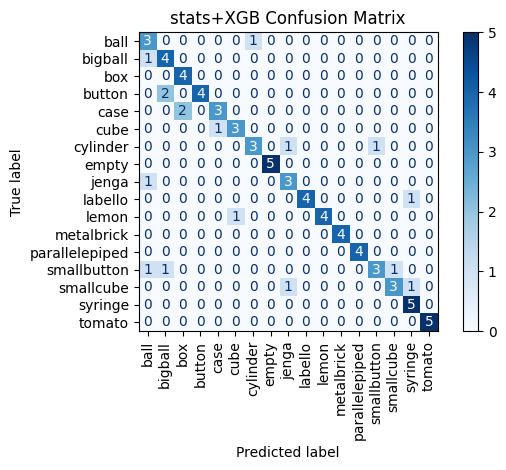

In [11]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)

Displaying feature importances:

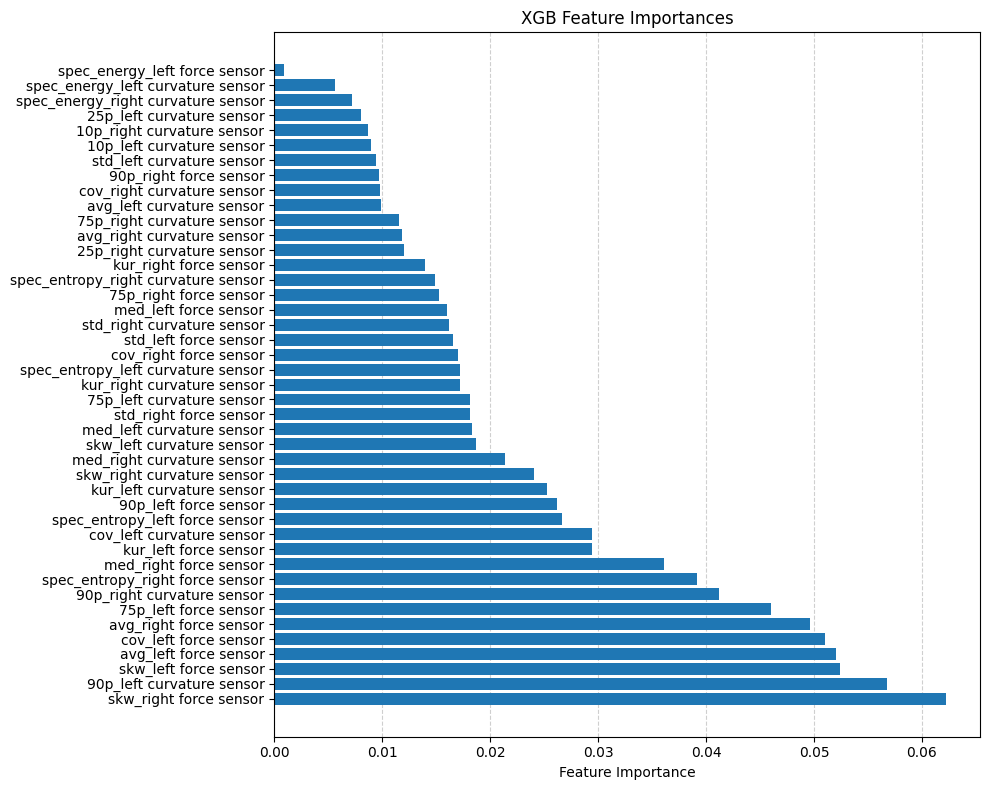

In [12]:
importances = best_model.feature_importances_
non_zero = importances > 0
sorted_idx = np.argsort(importances[non_zero])[::-1]
sorted_feats = X_train.columns[non_zero][sorted_idx]
sorted_imps = importances[non_zero][sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(sorted_feats, sorted_imps)
plt.xlabel('Feature Importance')
plt.title(f'XGB Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_feature_importances.png"))

Sensors appearing in the top feature importances:

In [13]:
top_cols = X_train.columns[non_zero][sorted_idx][:17]
sensors = [col.split('_')[-1] for col in top_cols]
sensors_counts = Counter(sensors)
df_sensors_counts = pd.DataFrame(sensors_counts.items(), columns=['Sensor', 'Count'])
df_sensors_counts = df_sensors_counts.sort_values(by='Count', ascending=False)
df_sensors_counts.style.background_gradient(cmap='Blues')

,Sensor,Count
2,left force sensor,7
0,right force sensor,4
1,left curvature sensor,3
3,right curvature sensor,3


Features appearing in the top feature importances:

In [14]:
features = [col.split('_')[0] for col in top_cols]
feature_counts = Counter(features)
df_feature_counts = pd.DataFrame(feature_counts.items(), columns=["Feature", "Count"])
df_feature_counts = df_feature_counts.sort_values(by="Count", ascending=False).reset_index(drop=True)
df_feature_counts.style.background_gradient(cmap='Blues')

,Feature,Count
0,skw,3
1,90p,3
2,avg,2
3,cov,2
4,spec,2
5,med,2
6,kur,2
7,75p,1
